<a href="https://colab.research.google.com/github/alifele/Brain_Computer_Interface-Competition-/blob/master/HAR_based_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/content/drive/My Drive/EEG_BCI/')
import datafetch
import plotters
import random


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
def History_plotter(his):
  his_list = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
  for i, name in enumerate(his_list):
    History[i]+=(his.history[name])
  plt.figure(figsize=(8, 5))
  plt.plot(np.array(History).T, '-')
  plt.legend(his_list)


In [0]:
under_sample =1
t = np.linspace(0,3,int(7200/under_sample))
f = np.linspace(1/3, 2400, int(7200/under_sample))

In [0]:
Data = []
class_list = ['none'] + [ 'train_data_class{}'.format(i+1) for i in range(4)]
Label = []


for i in range(15):
  subj = datafetch.fetch_subject(i+1)
  for class_ in range(1,5):
    for trial in range(25):
      Data.append(subj[class_list[class_]][trial][::under_sample, :])
      Label += [class_]

Data = np.array(Data)
Label = np.array(Label)

rnd = [i for i in range(1500)]
np.random.shuffle(rnd)

Data = Data[rnd]
Label = Label[rnd]

In [0]:
x_train, x_test, y_train, y_test = train_test_split(Data, Label, test_size = 0.1)
History = [[] for i in range(4)]


In [0]:
from pandas import DataFrame

In [0]:
import tensorflow as tf
from tensorflow import keras


In [0]:
model = keras.models.Sequential()

active = 'relu'

model.add(keras.layers.AvgPool1D(4, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=7, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=3, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(30, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling1d_2 (Average (None, 1800, 63)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1797, 30)          7590      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1797, 30)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1794, 30)          3630      
_________________________________________________________________
average_pooling1d_3 (Average (None, 897, 30)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 897, 30)           120       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 895, 20)          

In [0]:

model.compile(optimizer='adam', 
              metrics= ['accuracy'],
              loss= 'sparse_categorical_crossentropy')

In [62]:
his = model.fit(x_train, y_train-1, epochs=500, batch_size=5, validation_data=(x_test, y_test-1))

Epoch 1/500
270/270 [==============================] - 3s 11ms/step - loss: 1.0592 - accuracy: 0.5148 - val_loss: 1.2987 - val_accuracy: 0.3533
Epoch 2/500
270/270 [==============================] - 3s 10ms/step - loss: 1.0755 - accuracy: 0.5252 - val_loss: 1.2967 - val_accuracy: 0.3467
Epoch 3/500
270/270 [==============================] - 3s 11ms/step - loss: 1.0506 - accuracy: 0.5459 - val_loss: 1.3353 - val_accuracy: 0.3400
Epoch 4/500
270/270 [==============================] - 3s 11ms/step - loss: 1.0552 - accuracy: 0.5267 - val_loss: 1.2543 - val_accuracy: 0.4067
Epoch 5/500
270/270 [==============================] - 3s 11ms/step - loss: 1.0360 - accuracy: 0.5481 - val_loss: 1.3322 - val_accuracy: 0.3600
Epoch 6/500
270/270 [==============================] - 3s 11ms/step - loss: 1.0371 - accuracy: 0.5385 - val_loss: 1.2896 - val_accuracy: 0.3800
Epoch 7/500
270/270 [==============================] - 3s 11ms/step - loss: 1.0481 - accuracy: 0.5296 - val_loss: 1.2587 - val_accuracy:

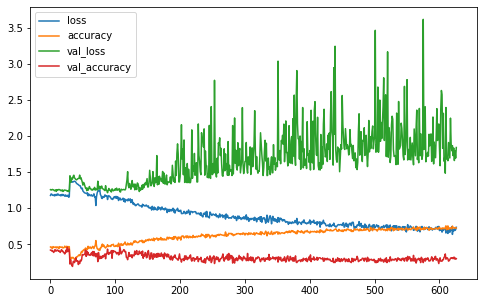

In [63]:
History_plotter(his)

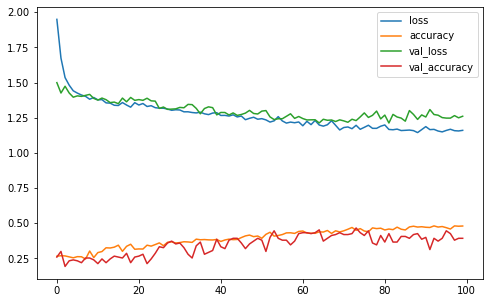

[1.1773306131362915,
 1.1978554725646973,
 1.1939903497695923,
 1.17960524559021,
 1.1781431436538696,
 1.1840314865112305,
 1.1703736782073975,
 1.1898702383041382,
 1.1748608350753784,
 1.1919866800308228]

In [35]:
np.shape(History)

(4, 10)

#DATA

## Lower fluctuation in validation loss function

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.AvgPool1D(1, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Conv1D(filters=35, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=3))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=25, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=7, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=3, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


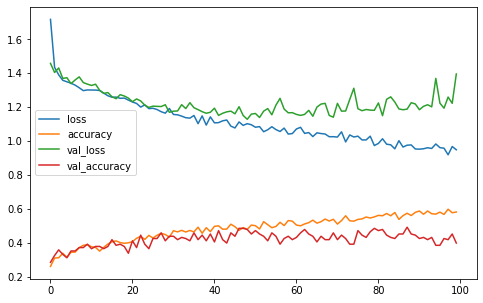

In [53]:
DataFrame(his.history).plot(figsize=(8, 5))


## All kernel sizes small

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.MaxPool1D(1, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=60, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Conv1D(filters=40, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=30, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=5, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))




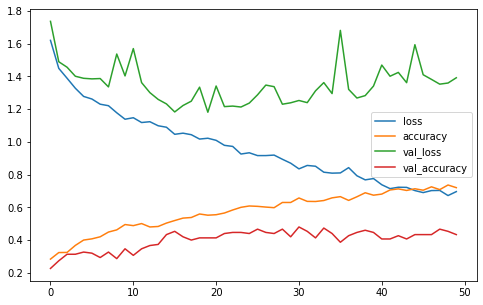

In [106]:
DataFrame(his.history).plot(figsize=(8, 5))


## All Kernel sizes are Large

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.MaxPool1D(1, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=60, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Conv1D(filters=40, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=30, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=5, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))




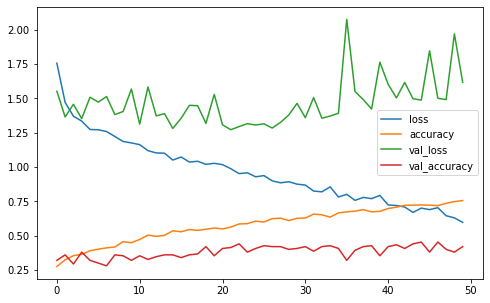

In [111]:
DataFrame(his.history).plot(figsize=(8, 5))


## Avg Pooling for all pooling layers

In [0]:
model = keras.models.Sequential()

active = 'selu'

model.add(keras.layers.AvgPool1D(1, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=60, kernel_size=5, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Conv1D(filters=40, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=30, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=5, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))


DataFrame(his.history).plot(figsize=(8, 5))


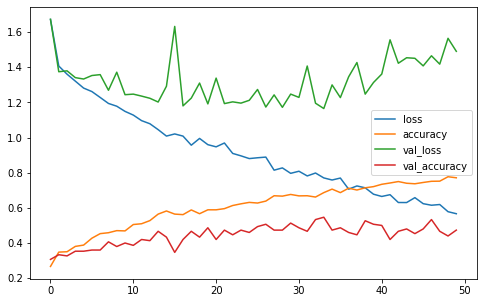

In [117]:
DataFrame(his.history).plot(figsize=(8, 5))


## Very Good Trace of losses

In [0]:
# The input signal is not under_sampled

model = keras.models.Sequential()

active = 'relu'

model.add(keras.layers.AvgPool1D(4, input_shape=(int(7200/under_sample),63) ))
model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv1D(filters=30, kernel_size=4, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.AvgPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=20, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=10, kernel_size=3, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=7, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(filters=3, kernel_size=2, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.MaxPool1D(pool_size=2))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=4))
model.add(keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(30, activation=active, kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation = active, kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax', kernel_initializer="he_normal"))

#Lower Fluctiotion in val_loss


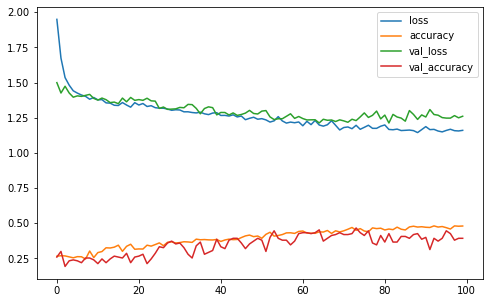

In [16]:
DataFrame(his.history).plot(figsize=(8, 5))


## A

## A

## A

## A

## A

## A